In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({"text.usetex":True}) # enable tex rendering in matplotlib

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_cdv, plot_latent_states_cdv
from tools.ae_v2 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-05-24 21:01:42.739900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 21:01:42.740581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 21:01:42.798868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 21:01:42.799166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 21:01:42.799398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '004'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    stddev_multiplier_pm = 1
    num_params = params_mat.shape[1]

    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    og_vars = all_data.shape[1]
    if alldata_withparams_flag == True:
        og_vars -= num_params

    if ae_data_with_params == False:
        stddev_multiplier_pm = None
    if normalizeforae_flag == False:
        stddev_multiplier = None

    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
        if normalization_type == 'stddev':
            sample_mean = np.mean(all_data, axis=0)
            sample_std = np.std(all_data, axis=0)
            normalization_constant_arr_aedata[0, :] = sample_mean
            normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
            if ae_data_with_params == True:
                normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
            zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
            if len(zero_idx) > 0:
                normalization_constant_arr_aedata[1, zero_idx] = 1.0
        elif normalization_type == 'minmax':
            for i in range(all_data.shape[1]):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        # if ae_data_with_params == True:
        #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
        #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'stddev_multiplier_pm':stddev_multiplier_pm,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[ 0.8598464 ,  0.20818995, -0.15084821, -0.4832867 , -0.19962065,
         0.18153833],
       [ 0.18234183,  0.22417355,  0.37001276,  0.33698028,  0.34491393,
         0.42713565]], dtype=float32)

# Autoencoder

In [22]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1.99491662e-06 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 2**6
    fRMS = 7.79229715e-03
    timeMeanofSpaceRMS = np.mean(np.mean(all_data[:, 0:og_vars]**2, axis=1)**0.5)
    
    dt_ae = 0.2
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:og_vars])
    contractive_lmda = 0.0
    use_weights_post_dense = True
    dropout_rate = 0.0
    
    print('stddev : ', stddev)

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'contractive_lmda':contractive_lmda,
        'dropout_rate':dropout_rate,
        'dt_ae':dt_ae,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        contractive_lmda = tparams_dict['contractive_lmda']
    except:
        print("'contractive_lmda' not in tparams_dict, set to 0")
        contractive_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

stddev :  0.0025974366408567833


In [23]:
all_data = all_data[0:370001]
boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = 1 + num_elems_pre_indexing//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([185001])

In [26]:
all_data.shape

(185001, 6)

In [27]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [28]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [29]:
#

In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 2
    # enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
    # enc_layers = [32, 16, 8, 4]
    # for i in range(len(enc_layers)):
    #     if latent_space_dim < enc_layers[-i-1]:
    #         enc_layers = enc_layers[0:-i]
    #         break
    #     if i == len(enc_layers)-1:
    #         enc_layers = []
    # dec_layers = enc_layers[::-1]
    enc_layers = [16, 8, 8]
    dec_layers = [8, 8, 16]
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                contractive_lmda=contractive_lmda,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            contractive_lmda=contractive_lmda,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [31]:
#

In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

train_ls_jacobian_norm_hist = []

train_real_MSE_hist = []
val_real_MSE_hist = []

train_params_MSE_hist = []
val_params_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

class real_MSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, og_vars, name='real_MSE', **kwargs):
        super().__init__(name, **kwargs)
        self.og_vars = og_vars

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, 0:self.og_vars]
        y_pred = y_pred[:, 0:self.og_vars]
        return super().update_state(y_true, y_pred, sample_weight)
    
class params_MSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, og_vars, name='params_MSE', **kwargs):
        super().__init__(name, **kwargs)
        self.og_vars = og_vars

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, self.og_vars:]
        y_pred = y_pred[:, self.og_vars:]
        return super().update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev)), real_MSE(og_vars), params_MSE(og_vars)]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    metric_to_use = 'val_mse'
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor=metric_to_use,
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor=metric_to_use,
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=True,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        train_ls_jacobian_norm_hist.append(history.history['ls_jacobian_norm'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0095 - mse: 0.0093 - NMSE: 0.0840 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 0.7688 - tot_time: 0h 0m 16.4s

Epoch 1: val_mse improved from inf to 0.00521, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 6ms/step - loss: 0.0095 - mse: 0.0093 - NMSE: 0.0839 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 0.7689 - val_loss: 0.0054 - val_mse: 0.0052 - val_NMSE: 0.0469 - val_real_MSE: 0.0052 - val_params_MSE: nan - val_ls_jac

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0024 - mse: 0.0021 - NMSE: 0.0190 - real_MSE: 0.0021 - params_MSE: nan - ls_jacobian_norm: 0.8984 - val_loss: 0.0022 - val_mse: 0.0020 - val_NMSE: 0.0178 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2304/2313 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0184 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.8950 - tot_time: 0h 3m 0.3s

Epoch 12: val_mse improved from 0.00198 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0020 - mse: 0.0017 - NMSE: 0.0156 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.8937 - val_loss: 0.0020 - val_mse: 0.0017 - val_NMSE: 0.0153 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0017 - NMSE: 0.0155 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.8985 - tot_time: 0h 5m 44.9s

Epoch 23: val_mse improved from 0.00166 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0020 - mse: 0.0017 - NMSE: 0.

2313/2313 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.8973 - tot_time: 0h 8m 28.4s

Epoch 34: val_mse did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.8973 - val_loss: 0.0019 - val_mse: 0.0016 - val_NMSE: 0.0140 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0144 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.9059 - tot_time: 0h 8m 44.4s

Epoch 35: val_mse did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0018 - mse: 0.0015 - NMSE: 0.0131 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.9343 - val_loss: 0.0017 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.9447 - tot_time: 0h 11m 32.6s

Epoch 46: val_mse did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0018 - mse: 0.0014 - NMSE: 0.0130 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.9449 - val_loss: 0.0018 - val_mse: 0.0014

2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.0556 - tot_time: 0h 14m 20.4s

Epoch 57: val_mse improved from 0.00128 to 0.00120, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.0554 - val_loss: 0.0015 - val_mse: 0.0012 - val_NMSE: 0.0108 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0013 - NMSE: 0.0113 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.0672 - tot_time: 0h 14m 35.9s

Epoch 58: val_mse did not improve f

2307/2313 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.0914 - tot_time: 0h 17m 11.0s

Epoch 68: val_mse improved from 0.00108 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0015 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.0914 - val_loss: 0.0014 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 69/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.1058 - tot_time: 0h 17m 26.7s

Epoch 69: val_mse did not improve f

Epoch 80/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 1.2119 - tot_time: 0h 20m 14.1s

Epoch 80: val_mse improved from 0.00098 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0014 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 1.2117 - val_loss: 0.0013 - val_mse: 9.5174e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5174e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 81/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 1.1827 - tot_time: 0h 20m 29.9s

Epoch 81: val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0013 - mse: 9.2688e-04 - NMSE: 0.0083 - real_MSE: 9.2688e-04 - params_MSE: nan - ls_jacobian_norm: 1.2651 - val_loss: 0.0012 - val_mse: 8.5663e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5663e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 92/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 9.0740e-04 - NMSE: 0.0082 - real_MSE: 9.0740e-04 - params_MSE: nan - ls_jacobian_norm: 1.2835 - tot_time: 0h 23m 27.2s

Epoch 92: val_mse did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0013 - mse: 9.0747e-04 - NMSE: 0.0082 - real_MSE: 9.0747e-04 - params_MSE: nan - ls_jacobian_norm: 1.2836 - va

Epoch 103/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 8.2982e-04 - NMSE: 0.0075 - real_MSE: 8.2982e-04 - params_MSE: nan - ls_jacobian_norm: 1.2356 - tot_time: 0h 26m 9.3s

Epoch 103: val_mse did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0012 - mse: 8.3017e-04 - NMSE: 0.0075 - real_MSE: 8.3017e-04 - params_MSE: nan - ls_jacobian_norm: 1.2356 - val_loss: 0.0012 - val_mse: 8.1995e-04 - val_NMSE: 0.0074 - val_real_MSE: 8.1995e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 104/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 8.1718e-04 - NMSE: 0.0074 - real_MSE: 8.1718e-04 - params_MSE: nan - ls_jacobian_norm: 1.2387 - tot_time: 0h 26m 23.3s

Epoch 104: val_mse improved from 0.00078 to 0.00077, saving model to /home/rkaushik/Documents/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0011 - mse: 7.8924e-04 - NMSE: 0.0071 - real_MSE: 7.8924e-04 - params_MSE: nan - ls_jacobian_norm: 1.2749 - val_loss: 0.0011 - val_mse: 7.2901e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2901e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 115/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 7.8590e-04 - NMSE: 0.0071 - real_MSE: 7.8590e-04 - params_MSE: nan - ls_jacobian_norm: 1.3007 - tot_time: 0h 29m 6.5s

Epoch 115: val_mse did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0011 - mse: 7.8592e-04 - NMSE: 0.0071 - real_MSE: 7.8592e-04 - params_MSE: nan - ls_jacobian_norm: 1.3009 - v

Epoch 126/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 7.5346e-04 - NMSE: 0.0068 - real_MSE: 7.5346e-04 - params_MSE: nan - ls_jacobian_norm: 1.3088 - tot_time: 0h 31m 58.4s

Epoch 126: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0011 - mse: 7.5382e-04 - NMSE: 0.0068 - real_MSE: 7.5382e-04 - params_MSE: nan - ls_jacobian_norm: 1.3088 - val_loss: 0.0011 - val_mse: 7.2571e-04 - val_NMSE: 0.0065 - val_real_MSE: 7.2571e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 127/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 7.5895e-04 - NMSE: 0.0068 - real_MSE: 7.5895e-04 - params_MSE: nan - ls_jacobian_norm: 1.3193 - tot_time: 0h 32m 13.8s

Epoch 127: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Do

Epoch 138/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 7.4724e-04 - NMSE: 0.0067 - real_MSE: 7.4724e-04 - params_MSE: nan - ls_jacobian_norm: 1.3195Restoring model weights from the end of the best epoch: 128.
 - tot_time: 0h 35m 3.1s

Epoch 138: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0011 - mse: 7.4719e-04 - NMSE: 0.0067 - real_MSE: 7.4719e-04 - params_MSE: nan - ls_jacobian_norm: 1.3193 - val_loss: 0.0011 - val_mse: 7.8640e-04 - val_NMSE: 0.0071 - val_real_MSE: 7.8640e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 138: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------

Epoch 11/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.7191e-04 - NMSE: 0.0060 - real_MSE: 6.7191e-04 - params_MSE: nan - ls_jacobian_norm: 1.2949 - tot_time: 0h 37m 56.4s

Epoch 11: val_mse did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0010 - mse: 6.7191e-04 - NMSE: 0.0060 - real_MSE: 6.7191e-04 - params_MSE: nan - ls_jacobian_norm: 1.2949 - val_loss: 9.7194e-04 - val_mse: 6.1806e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.1806e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.6946e-04 - NMSE: 0.0060 - real_MSE: 6.6946e-04 - params_MSE: nan - ls_jacobian_norm: 1.3113 - tot_time: 0h 38m 12.5s

Epoch 12: val_mse did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Do

2306/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.6634e-04 - NMSE: 0.0060 - real_MSE: 6.6634e-04 - params_MSE: nan - ls_jacobian_norm: 1.3148 - tot_time: 0h 40m 54.3s

Epoch 22: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0010 - mse: 6.6640e-04 - NMSE: 0.0060 - real_MSE: 6.6640e-04 - params_MSE: nan - ls_jacobian_norm: 1.3150 - val_loss: 9.7731e-04 - val_mse: 6.2287e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2287e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.6478e-04 - NMSE: 0.0060 - real_MSE: 6.6478e-04 - params_MSE: nan - ls_jacobian_norm: 1.3023 - tot_time: 0h 41m 10.6s

Epoch 23: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesi

Epoch 34/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.6259e-04 - NMSE: 0.0060 - real_MSE: 6.6259e-04 - params_MSE: nan - ls_jacobian_norm: 1.3056 - tot_time: 0h 44m 11.0s

Epoch 34: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0010 - mse: 6.6260e-04 - NMSE: 0.0060 - real_MSE: 6.6260e-04 - params_MSE: nan - ls_jacobian_norm: 1.3058 - val_loss: 9.6441e-04 - val_mse: 6.1029e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1029e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.6078e-04 - NMSE: 0.0059 - real_MSE: 6.6078e-04 - params_MSE: nan - ls_jacobian_norm: 1.3036 - tot_time: 0h 44m 27.6s

Epoch 35: val_mse improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents

2313/2313 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.5890e-04 - NMSE: 0.0059 - real_MSE: 6.5890e-04 - params_MSE: nan - ls_jacobian_norm: 1.3021 - tot_time: 0h 47m 0.5s

Epoch 45: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0010 - mse: 6.5890e-04 - NMSE: 0.0059 - real_MSE: 6.5890e-04 - params_MSE: nan - ls_jacobian_norm: 1.3021 - val_loss: 9.5835e-04 - val_mse: 6.0452e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0452e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.5950e-04 - NMSE: 0.0059 - real_MSE: 6.5950e-04 - params_MSE: nan - ls_jacobian_norm: 1.2884 - tot_time: 0h 47m 15.9s

Epoch 46: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis

Epoch 57/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.5615e-04 - NMSE: 0.0059 - real_MSE: 6.5615e-04 - params_MSE: nan - ls_jacobian_norm: 1.3082Restoring model weights from the end of the best epoch: 47.
 - tot_time: 0h 50m 6.5s

Epoch 57: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0010 - mse: 6.5620e-04 - NMSE: 0.0059 - real_MSE: 6.5620e-04 - params_MSE: nan - ls_jacobian_norm: 1.3082 - val_loss: 9.5914e-04 - val_mse: 6.0582e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0582e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------

Epoch 11/200
2308/2313 [============================>.] - ETA: 0s - loss: 9.9843e-04 - mse: 6.4481e-04 - NMSE: 0.0058 - real_MSE: 6.4481e-04 - params_MSE: nan - ls_jacobian_norm: 1.2972Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 52m 55.1s

Epoch 11: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 9.9837e-04 - mse: 6.4475e-04 - NMSE: 0.0058 - real_MSE: 6.4475e-04 - params_MSE: nan - ls_jacobian_norm: 1.2970 - val_loss: 9.4926e-04 - val_mse: 5.9563e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9563e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11: early stopping


In [36]:
temp = []
for lst in train_ls_jacobian_norm_hist:
    temp.extend(lst)
train_ls_jacobian_norm_hist_og = train_ls_jacobian_norm_hist
train_ls_jacobian_norm_hist = np.array(temp)

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_net.evaluate(training_data, training_data)
    val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_ls_jacobian_norm_hist':train_ls_jacobian_norm_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

579/579 [==============================] - 2s 3ms/step - loss: 9.4917e-04 - mse: 5.9565e-04 - NMSE: 0.0054 - real_MSE: 5.9565e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


In [38]:
print('lr_change : ', lr_change)

lr_change :  [0, 138, 195, 206]


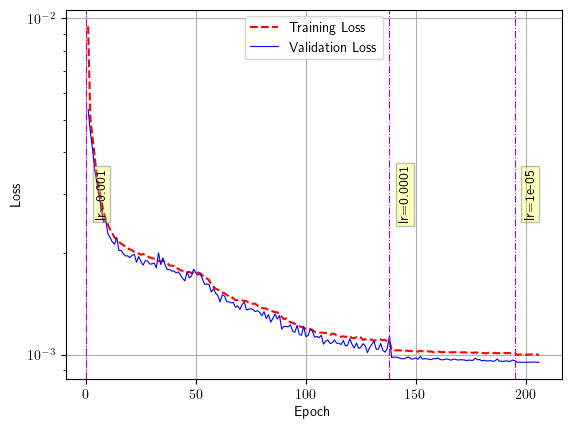

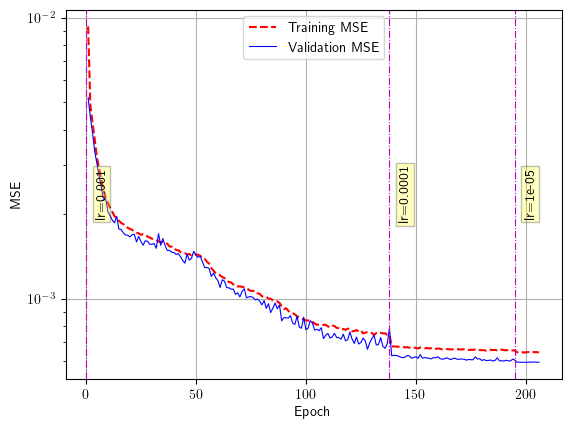

<Figure size 640x480 with 0 Axes>

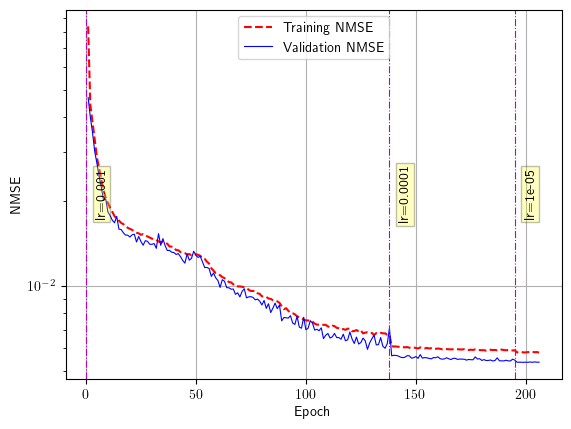

<Figure size 640x480 with 0 Axes>

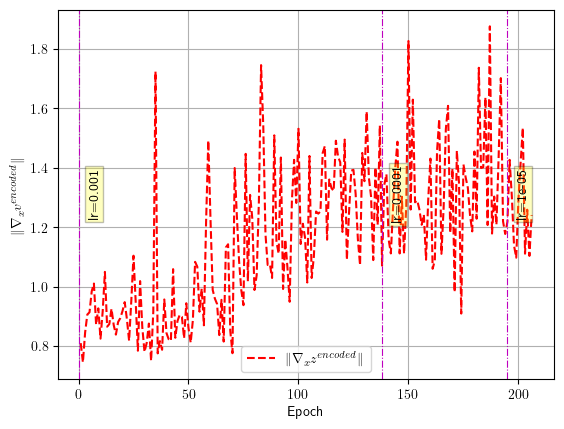

<Figure size 640x480 with 0 Axes>

In [39]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_ls_jacobian_norm_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\| \nabla_{x} z^{encoded} \|$"],
    xlabel='Epoch',
    ylabel=r"$\| \nabla_{x} v^{encoded} \|$",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_ls_jacobian_norm_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [40]:
reconstructed_data = ae_net.predict(all_data)

In [41]:
plot_reconstructed_data_cdv(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data,
    params_mat,
    delta_t,
    save_figs=True)

In [42]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

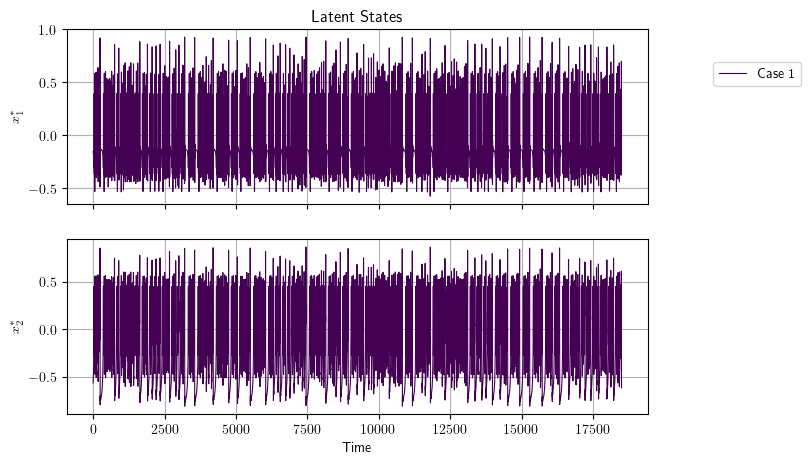

In [43]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    params_mat,
    save_config_path=dir_name_plot)
fig.savefig(dir_name_plot+'/latent_states.png', dpi=300, bbox_inches='tight')

In [44]:
# fig.savefig(dir_name_plot+'/latent_states.png', dpi=300, bbox_inches='tight')

In [45]:
# ae_net.summary()

# KE and Dissipation

In [46]:
if ae_net.use_weights_post_dense == True:
    print(ae_net.decoder_layers_list[-1].individual_weights)

<tf.Variable 'single_weights/individual_weights:0' shape=(6,) dtype=float32, numpy=
array([1.4197407, 1.8039479, 0.937332 , 1.2379377, 2.080841 , 1.2862147],
      dtype=float32)>
